In [52]:
import numpy as np
import pandas as pd
import os
from collections import Counter
import string

#stats
from scipy.stats import chi2_contingency, ttest_ind, levene, kruskal, shapiro, f_oneway
from scipy.stats.contingency import odds_ratio
from statsmodels.stats.power import TTestPower, TTestIndPower
#geo
import geopandas as gpd
import contextily as cx
from shapely import wkt
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union
import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation, plot_moran
from esda.moran import Moran, Moran_Local
from libpysal import weights
from splot.libpysal import plot_spatial_weights
from libpysal.weights import KNN, DistanceBand
from libpysal.weights.util import nonplanar_neighbors

#plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from adjustText import adjust_text
from matplotlib.lines import Line2D
import matplotlib.image as mpimg

In [53]:
def save_csv(df, output_path, index=False, encoding="utf-8"):
    """Save csv and create folder if it doesn't yet exist."""
    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)
    df.to_csv(output_path, index=index, encoding=encoding)

In [54]:
def get_averages(df, col="sprachgis_dialect", var="percent_s", min_size=1, multimembership=False):
    if not multimembership:
        # Categorical mode (e.g., "Low" vs "NOT Low")
        df[col] = df[col].fillna("None")
        grouped = df.groupby(col)[var].agg(['count', 'mean', 'median'])
        grouped.columns = ["n_group", "mean_group", "med_group"]
        grouped["n_others"] = df.shape[0] - grouped["n_group"]

        results = []
        for group_name, row in grouped.iterrows():
            if row["n_group"] < min_size or row["n_others"] < min_size:
                continue

            mask = df[col] == group_name
            group_vals = df.loc[mask, var]
            other_vals = df.loc[~mask, var]

            t_stat, p_val = ttest_ind(group_vals, other_vals, equal_var=False, nan_policy="omit")

            results.append({
                "group": group_name,
                "n_group": int(row["n_group"]),
                "n_others": int(row["n_others"]),
                "mean_group": row["mean_group"],
                "mean_others": other_vals.mean(),
                "med_group": row["med_group"],
                "med_others": other_vals.median(),
            })

        results_df = pd.DataFrame(results)

    else:
        # Multi-membership mode (e.g., composite dialects)
        def clean_and_split_dialects(val):
            val = val.translate(str.maketrans("", "", string.punctuation))
            parts = [part.strip() for part in val.split(",") if part.strip()]
            dialects = []
            for p in parts:
                dialects.extend(p.split())
            return dialects

        df[col] = df[col].fillna("")
        df["variable_list"] = df[col].apply(clean_and_split_dialects)

        all_dialects = sorted(set(d for sublist in df["variable_list"] for d in sublist))
        membership = pd.DataFrame(0, index=df.index, columns=all_dialects)

        for idx, dialects in df["variable_list"].items():
            for d in dialects:
                membership.at[idx, d] = 1

        results = []
        for dialect in membership.columns:
            group_mask = membership[dialect] == 1
            rest_mask = membership[dialect] == 0

            n_group = group_mask.sum()
            n_others = rest_mask.sum()

            if n_group < min_size or n_others < min_size:
                continue

            group_vals = df.loc[group_mask, var]
            other_vals = df.loc[rest_mask, var]

            results.append({
                "group": dialect,
                "n_group": int(n_group),
                "n_others": int(n_others),
                "mean_group": group_vals.mean(),
                "mean_others": other_vals.mean(),
                "med_group": group_vals.median(),
                "med_others": other_vals.median(),
            })

        results_df = pd.DataFrame(results)

        numeric_cols = ["n_group", "n_others", "mean_group", "mean_others", "med_group", "med_others"]
        results_df = results_df.groupby("group", as_index=False)[numeric_cols].mean()

    # # Add multiple testing correction
    # if not results_df.empty:
    #     reject, pvals_bonf, _, _ = multipletests(results_df["p"], method="bonferroni")
    #     results_df["p_bonf"] = pvals_bonf
    #     results_df["reject_bonf"] = reject

    return results_df


# Power calculations

0.1: 786
0.2: 198
0.3: 89
0.4: 51
0.5: 33
0.6: 23
0.7: 18
0.8: 14
0.9: 11


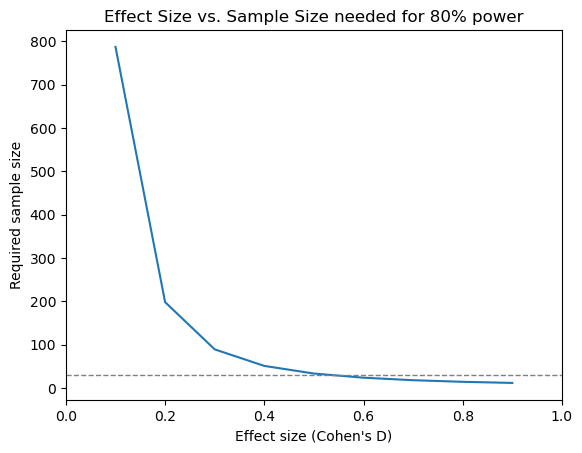

In [55]:
#required sample size for 80% power
#smaller sample sizes with 20-30 paricipants can detect moderate-large effect sizes (.5-.6)
effect_sizes = []
sample_sizes = []
analysis = TTestPower()

for i in range(1, 10, 1):
    effect_size = i / 10
    alpha = 0.05
    power = 0.8
    sample_size = analysis.solve_power(effect_size=effect_size, power=power, alpha=alpha, alternative="two-sided")
    effect_sizes.append(effect_size)
    sample_sizes.append(sample_size)
    print(f"{effect_size}: {int(sample_size)}")

plt.plot(effect_sizes, sample_sizes, '-')
plt.xlabel("Effect size (Cohen's D)")
plt.xlim(0, 1)
plt.ylabel("Required sample size")
plt.title("Effect Size vs. Sample Size needed for 80% power")
plt.axhline(y=30, color='grey', linestyle='--', linewidth=1)

plt.show()

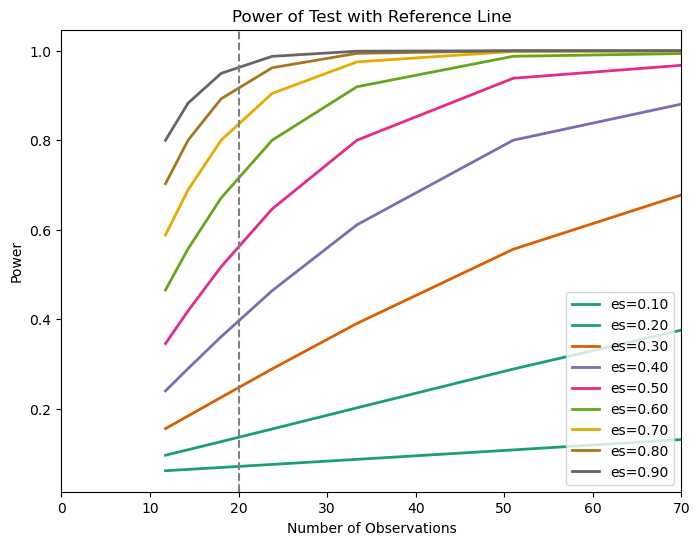

Power for d=0.1: 0.076
Power for d=0.2: 0.155
Power for d=0.30000000000000004: 0.290
Power for d=0.4: 0.466
Power for d=0.5: 0.649
Power for d=0.6: 0.803
Power for d=0.7000000000000001: 0.907
Power for d=0.8: 0.963
Power for d=0.9: 0.988
Power for d=1.0: 0.997


In [56]:
#plot power curve
#how power changes for different effect sizes as sample size increase
#to find medium effect size (0.5): 80% power with 60-70 per group
fig, ax = plt.subplots(figsize=(8, 6))

analysis.plot_power(dep_var="nobs", nobs=np.array(sample_sizes),effect_size=np.array(effect_sizes), ax=ax)

ax.axvline(x=20, color="grey", linestyle="--")
ax.set_title("Power of Test with Reference Line")
ax.set_xlim(0,70)
plt.ylabel("Power")
plt.show()

#power with a sample size of 25 in one group and 194 in the other
analysis = TTestIndPower()
effect_sizes = np.linspace(0.1, 1.0, 10)

alpha = 0.05
nobs1 = 25
ratio = 194 / 25  # n2 / n1

for e in effect_sizes:
    power = analysis.power(effect_size=(e), nobs1=nobs1, alpha=alpha, ratio=ratio)
    print(f"Power for d={e}: {power:.3f}")


# Statistical tests

In [57]:
#load data
df = pd.read_csv("./data/data_for_plotting.csv")
df.head()

respondent  bilingual    age  gender              dialects years_abroad  \
0           1          0  19-30     0.0  bairisch, schwäbisch          10+   
1           2          1  19-30     0.0                 keine          1-5   
2           3          1  19-30     0.0          kärntnerisch           <1   
3           4          0  19-30     1.0           thüringisch           <1   
4           5          0  19-30     1.0              bairisch           <1   

  time_abroad_place der Park der Biskuit der Jodel  ... das Brolck  \
0               NaN    parks    biskuits     jodel  ...    brolcke   
1               NaN    parks    biskuits     jodel  ...    brolcks   
2               NaN    parks    biskuits     jodel  ...    brolcke   
3               NaN    parks    biskuits     jodel  ...   brolcken   
4               NaN    parks     biskuit     jodel  ...    brolcke   

  total_tokens dialect_count        sprachgis_dialect regional_group  \
0           42             2  Bairisch_DE, Schwäbisch           High   
1           42             0                      NaN            NaN   
2           42             1              Südbairisch           High   
3           42             1              Thüringisch        Central   
4           42             1              Bairisch_DE           High   

  low_vs_notlow  country former_GDR total_s percent_s  
0       Not Low  Germany      False    13.0     39.39  
1       Not Low      NaN      False    16.0     48.48  
2       Not Low  Austria      False    15.0     46.88  
3       Not Low  Germany       True     9.0     28.12  
4       Not Low  Germany      False    11.0     34.38  

[5 rows x 49 columns]

In [58]:
df["percent_s"].describe()

count    219.000000
mean      43.190502
std       10.507230
min       15.150000
25%       36.360000
50%       42.420000
75%       50.000000
max       69.700000
Name: percent_s, dtype: float64

In [59]:
#check normailty
print(shapiro(df["total_s"])) #not normally distributed
print(shapiro(df["percent_s"])) #normally distributed

ShapiroResult(statistic=0.9869741557168454, pvalue=0.04283981519654567)
ShapiroResult(statistic=0.9909888147731941, pvalue=0.19297885686812766)


# Low vs Not Low
- Not weighted - discard multi membership: independent samples 
- paired Welch's t-test p=0.9 (non-significant)

In [60]:
#drop no affiliation
df = df[df["dialects"] != "keine"].copy()

# define groups
group1_low = df[df["low_vs_notlow"] == "Low"]
group2_notlow = df[df["low_vs_notlow"] == "Not Low"]

#define significance
alpha = 0.05

#check variance
#percent
print(np.var(group1_low["percent_s"]), np.var(group2_notlow["percent_s"]))
print(levene(group1_low["percent_s"], group2_notlow["percent_s"], center='median')) #variances are unequal and so should use Welch not Student
#conduct t-test
print(ttest_ind(group1_low["percent_s"], group2_notlow["percent_s"], equal_var= False)) #not significant

166.13098899793385 95.21381794584208
LeveneResult(statistic=7.433498161433005, pvalue=0.006970643874267673)
TtestResult(statistic=0.08252343717783543, pvalue=0.9345187245693436, df=57.173143984964845)


In [61]:
df_notlow = get_averages(df, col="low_vs_notlow", var="percent_s", multimembership=False)
df_notlow

group  n_group  n_others  mean_group  mean_others  med_group  med_others
0      Low       44       158   42.842955    42.668481      42.42       42.42
1  Not Low      158        44   42.668481    42.842955      42.42       42.42

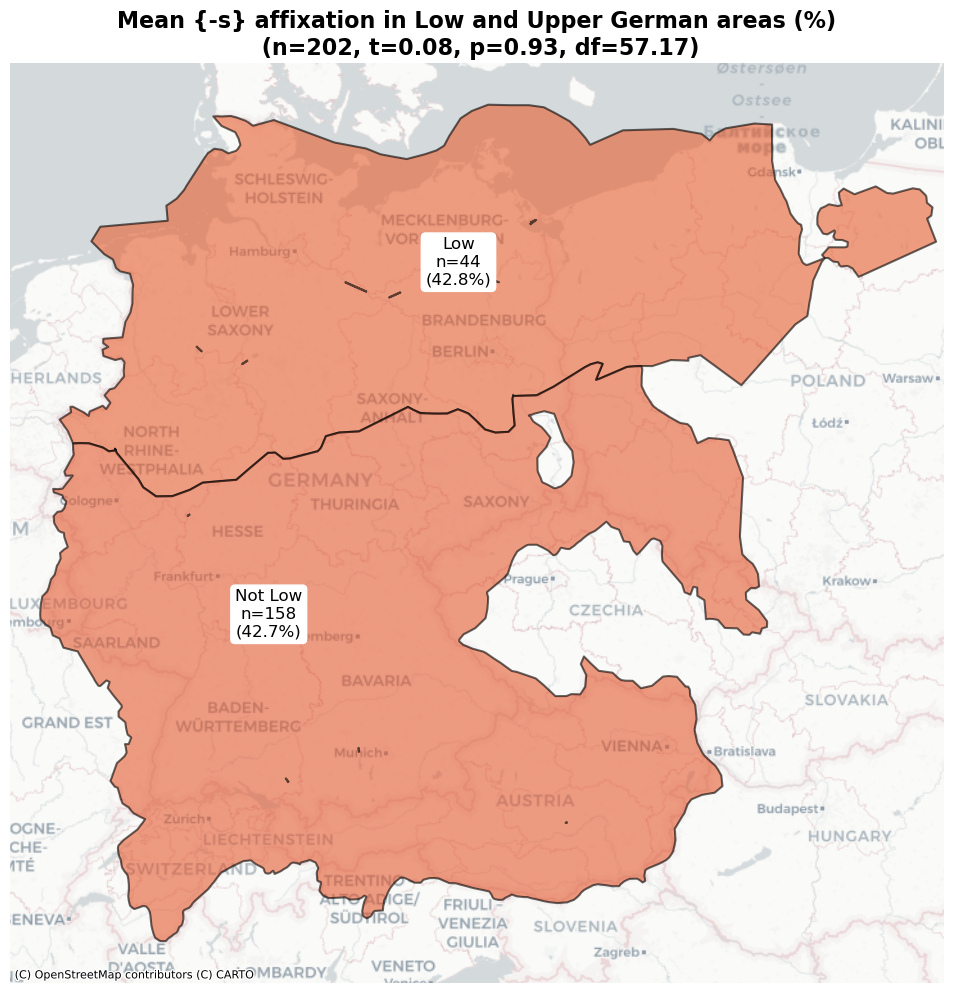

In [62]:
#load geometry
low_gjson_mercator = gpd.read_file("./geojson/low_gdf_mercator.geojson")
notlow_gjson_mercator = gpd.read_file("./geojson/not_low_gdf_mercator.geojson")
low_gjson_mercator["group"] = "Low"
notlow_gjson_mercator["group"] = "Not Low"
gdf_gjson_mercator_low = pd.concat([low_gjson_mercator, notlow_gjson_mercator], ignore_index=True)

#merge geometry with df
results_df = pd.merge(df_notlow, gdf_gjson_mercator_low, on="group")
results_gdf = gpd.GeoDataFrame(results_df, geometry="geometry")

gdf_gjson_mercator_low = gdf_gjson_mercator_low.merge(results_gdf[["group", "mean_group", "n_group"]], on="group", how="left")

#plot
texts = [] #for adjust_text labelling

#outlines
fig1, ax1 = plt.subplots(figsize=(10, 10))
gdf_gjson_mercator_low.plot(ax=ax1, column="mean_group",
    cmap="inferno", edgecolor="black", linewidth=1.5,alpha=0.6,
    vmin=27, vmax=52,
    #legend=True, legend_kwds={'label': "Mean % of plural nouns marked with {-s}", 'shrink': 0.6},
)

# Add basemap
cx.add_basemap(ax1, source=cx.providers.CartoDB.Positron, crs=gdf_gjson_mercator_low.crs)

# Title
ax1.set_title("Mean {-s} affixation in Low and Upper German areas (%)\n (n=202, t=0.08, p=0.93, df=57.17)", fontsize=16, fontweight="bold")

# Add labels with values
texts = []
for idx, row in gdf_gjson_mercator_low.iterrows():
    if pd.isna(row["mean_group"]):
        continue
    point = row.geometry.representative_point()
    label = row["group"]
    n = row["n_group"]
    value = row["mean_group"]
  
    x, y = point.x, point.y

    text_str = f"{label}\nn={int(n)}\n({value:.1f}%)"
    txt = ax1.text(x, y, text_str, fontsize=12, ha="center",
                  bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.3"))
    texts.append(txt)

adjust_text(texts, ax=ax1)

ax1.set_xlim(570000, 2350000)
ax1.set_axis_off()

plt.tight_layout()
plt.show()

# High vs Central vs Low
- only those with single group: independent samples
- 3 group ANOVA (non significant: p=0.46)


In [63]:
# define groups - no mixed 
group1h = df[df["regional_group"] == "High"]
group2b = df[df["regional_group"] == "Central"]
group3c = df[df["regional_group"] == "Low"]

#check variance
print(np.var(group1h["percent_s"]), np.var(group2b["percent_s"]), np.var(group3c["percent_s"]))
print(levene(group1h["percent_s"],group2b["percent_s"], group3c["percent_s"], center='median')) #variances are unequal and so should use Kruksal-Wallis
#conduct Kruksal
print(kruskal(group1h["percent_s"],group2b["percent_s"], group3c["percent_s"])) #not significant

77.04099103705833 159.42636523437503 210.62432840236687
LeveneResult(statistic=9.620556761525869, pvalue=0.00010921575024230394)
KruskalResult(statistic=0.5786708852995298, pvalue=0.7487609968991615)


In [64]:
df_hcl= get_averages(df, col="regional_group", var="percent_s", multimembership=False)
df_hcl

group  n_group  n_others  mean_group  mean_others  med_group  \
0             Central       32       170   40.261875    43.166647      42.42   
1        Central, Low        7       195   46.554286    42.568359      45.45   
2                High      118        84   43.004746    42.287500      42.42   
3       High, Central        8       194   47.335000    42.515619      45.45   
4  High, Central, Low        3       199   46.466667    42.649799      54.55   
5           High, Low        8       194   40.526250    42.796392      42.42   
6                 Low       26       176   42.138462    42.790398      41.57   

   med_others  
0       42.42  
1       42.42  
2       42.42  
3       42.42  
4       42.42  
5       42.42  
6       42.42

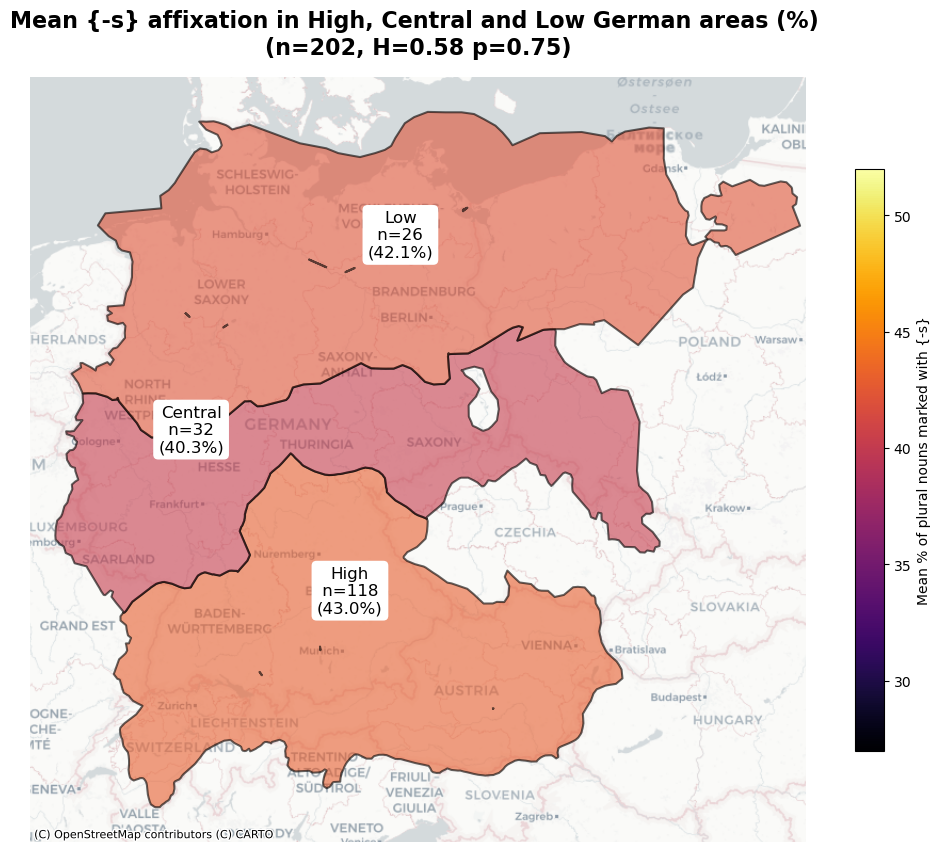

In [65]:
#load geojson data for adding to results
high = gpd.read_file("./geojson/high_gdf_mercator.geojson")
central = gpd.read_file("./geojson/central_gdf_mercator.geojson")
low = gpd.read_file("./geojson/low_gdf_mercator.geojson")
high["group"] = "High"
central["group"] = "Central"
low["group"] = "Low"
gdf_gjson_mercator_hcl = pd.concat([high, central, low], ignore_index=True)

results_df = pd.merge(df_hcl, gdf_gjson_mercator_hcl, on="group")
results_gdf = gpd.GeoDataFrame(results_df, geometry="geometry")

gdf_gjson_mercator_hcl = gdf_gjson_mercator_hcl.merge(results_gdf[["group", "mean_group", "n_group"]], on="group", how="left")

# Plot heatmap choropleth

#outlines
low_gjson_mercator = gpd.read_file("./geojson/low_gdf_mercator.geojson")
notlow_gjson_mercator = gpd.read_file("./geojson/not_low_gdf_mercator.geojson")

fig2, ax2 = plt.subplots(figsize=(10, 10))
gdf_gjson_mercator_hcl.plot(ax=ax2, column="mean_group",
    cmap="inferno", edgecolor="black", linewidth=1.5,alpha=0.6,
    vmin=27, vmax=52,
    legend=True, legend_kwds={'label': "Mean % of plural nouns marked with {-s}", 'shrink': 0.6},
)

# Add basemap
cx.add_basemap(ax2, source=cx.providers.CartoDB.Positron, crs=gdf_gjson_mercator_hcl.crs)

# Title
ax2.set_title("Mean {-s} affixation in High, Central and Low German areas (%) \n(n=202, H=0.58 p=0.75)", fontsize=16, fontweight="bold")

# Add labels with values
texts = []
for idx, row in gdf_gjson_mercator_hcl.iterrows():
    if pd.isna(row["mean_group"]):
        continue
    point = row.geometry.representative_point()
    label = row["group"]
    n = row["n_group"]
    value = row["mean_group"]
  
    x, y = point.x, point.y

    text_str = f"{label}\n n={int(n)} \n({value:.1f}%)"
    txt = ax2.text(x, y, text_str, fontsize=12, ha="center",
                  bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.3"))
    texts.append(txt)

adjust_text(texts, ax=ax2)

ax2.set_xlim(570000, 2350000)
ax2.set_axis_off()

plt.tight_layout()
plt.show()

In [66]:
#comparng north south
df = pd.read_csv("./data/data_for_plotting.csv")
tok_cols = [c for c in df.columns if c.startswith(("der ", "die ", "das "))]

# wide > long df
long = (
    df.melt(id_vars=["respondent", "regional_group"], #fixed
            value_vars=tok_cols,
            var_name="item_id", #random
            value_name="plural")
      .assign(is_s=lambda d: d["plural"].astype(str)
                                         .str.strip()
                                         .str.lower()
                                         .str.endswith("s")
                                         .astype(int))
)

long = long[long["regional_group"].isin(["Low", "Central", "High"])]
long["regional_group"] = pd.Categorical(long["regional_group"], categories=["Low", "Central", "High"])
long = long.dropna(subset=["is_s", "regional_group", "respondent", "item_id"])

#make stats relative to Low category (otherwise alphabetical)
long["regional_group"] = pd.Categorical(long["regional_group"], categories=["Low", "Central", "High"])

# run GLMM (Bayesian model)
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM

vc = {"speaker": "0 + C(respondent)",
      "item"   : "0 + C(item_id)"}

model = BinomialBayesMixedGLM.from_formula(
            "is_s ~ C(regional_group)",             # Low vs. Central vs. High
            vc_formulas=vc,
            data=long
).fit_vb()

print(model.summary())
#central region slightly less likely to use s, but high region more likely 

from scipy.special import expit

# % chance of using s, LCH: 
print(expit(-0.6519), expit(-0.6519 + (-0.1167)), expit(-0.6519 + 0.1659))


                        Binomial Mixed GLM Results
                             Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
---------------------------------------------------------------------------
Intercept                       M    -0.6519   0.0368                      
C(regional_group)[T.Central]    M    -0.1167   0.0873                      
C(regional_group)[T.High]       M     0.1659   0.0447                      
speaker                         V    -0.3724   0.0533 0.689   0.619   0.767
item                            V     0.8068   0.1207 2.241   1.760   2.853
Parameter types are mean structure (M) and variance structure (V)
Variance parameters are modeled as log standard deviations
0.34256150448821127 0.316782032158917 0.3808363171006393


# East West

In [67]:
# define groups - no mixed 
group1e = df[df["former_GDR"] == True]
group2w = df[df["former_GDR"] == False]

#percent
print(levene(group1e["percent_s"], group2w["percent_s"], center='median')) #variances are equal
#Student
print(ttest_ind(group1e["percent_s"], group2w["percent_s"], equal_var= True)) #not significant

LeveneResult(statistic=3.267519595944669, pvalue=0.07204913982286394)
TtestResult(statistic=-1.8848341675023064, pvalue=0.06078873397714714, df=217.0)


In [68]:
#datscha specifically 

#chi2
df = df.dropna(subset=["die Datscha"])
df["datscha_s"] = df["die Datscha"].str.lower().str.endswith("s").astype(int)
table = pd.crosstab(df["former_GDR"], df["datscha_s"])
chi2, p, dof, expected = chi2_contingency(table)

#cramer's v
n = table.sum().sum()  # total observations
phi2 = chi2 / n
r, k = table.shape
cramers_v = np.sqrt(phi2 / min(r - 1, k - 1))


print("Contingency table:")
print(table)
print(f"\nChi-square: {chi2:.3f}, p-value: {p:.4f}")
print(f"Cramér's V: {cramers_v:.3f}")


Contingency table:
datscha_s    0   1
former_GDR        
False       98  89
True        23   7

Chi-square: 5.224, p-value: 0.0223
Cramér's V: 0.155


# Dialects
- 17 group ANOVA (non-significant: p=0.14)

In [69]:
def simple_anova(df, col, var):
    
    df = df.copy()
    df[col] = df[col].fillna("None")

    # Define groups based on the specified column
    target_groups = df[col].unique()
    group_data = [df[df[col] == group][var].dropna() for group in target_groups]

    # Check variance
    levene_stat, levene_p = levene(*group_data, center='median')

    # Conduct ANOVA
    anova_stat, anova_p = f_oneway(*group_data)

    # Kruskal-Wallis (non-parametric)
    kruskal_stat, kruskal_p = kruskal(*group_data)

    # Summarise per group
    results_count = pd.DataFrame({
        "group": target_groups,
        "n_group": [len(g) for g in group_data],
        "variance": [np.var(g, ddof=1) for g in group_data],
        "median_group": [np.median(g) for g in group_data],
        "mean_group": [np.mean(g) for g in group_data],
    })

    # Add test results to summary
    results_count["levene_p"] = levene_p
    results_count["levene_stat"] = levene_stat
    results_count["kruskal_p"] = kruskal_p
    results_count["kruskal_stat"] = kruskal_stat
    results_count["anova_p"] = anova_p
    results_count["anova_stat"] = anova_stat
    return results_count

In [70]:
df_single_dialect = df[~df["sprachgis_dialect"].str.contains(",", na=False)]
results_dialect = simple_anova(df_single_dialect, col="sprachgis_dialect", var="percent_s")
results_dialect

group  n_group    variance  median_group  \
0                           None       17   68.961378        48.480   
1                    Südbairisch        9  104.340978        42.420   
2                    Thüringisch        2  207.264800        38.300   
3                    Bairisch_DE       14   67.078991        42.420   
4                       Hessisch        3  346.685033        21.210   
5                     Schwäbisch        9   66.195650        45.450   
6                      Steirisch       26  105.469098        42.420   
7                    Westfälisch        9  278.213250        36.360   
8                      Sächsisch        4  278.381667        21.970   
9                    Bairisch_AT       17   30.760476        45.450   
10                   Alemannisch        6  178.838707        43.935   
11             Nordniederdeutsch        9  204.711203        45.450   
12                     Fränkisch        5   72.510470        46.670   
13                  Berlinerisch        6  117.576137        34.845   
14                    Ripuarisch       10  158.958600        42.420   
15  Mecklenburgisch-Vorpommersch        1         NaN        24.240   
16                    Schlesisch        1         NaN        51.610   

    mean_group  levene_p  levene_stat  kruskal_p  kruskal_stat   anova_p  \
0    48.941765  0.183275     1.338967   0.316388     18.129166  0.076896   
1    41.664444  0.183275     1.338967   0.316388     18.129166  0.076896   
2    38.300000  0.183275     1.338967   0.316388     18.129166  0.076896   
3    42.712857  0.183275     1.338967   0.316388     18.129166  0.076896   
4    28.786667  0.183275     1.338967   0.316388     18.129166  0.076896   
5    44.033333  0.183275     1.338967   0.316388     18.129166  0.076896   
6    43.172308  0.183275     1.338967   0.316388     18.129166  0.076896   
7    42.590000  0.183275     1.338967   0.316388     18.129166  0.076896   
8    27.770000  0.183275     1.338967   0.316388     18.129166  0.076896   
9    44.204118  0.183275     1.338967   0.316388     18.129166  0.076896   
10   44.443333  0.183275     1.338967   0.316388     18.129166  0.076896   
11   45.264444  0.183275     1.338967   0.316388     18.129166  0.076896   
12   43.272000  0.183275     1.338967   0.316388     18.129166  0.076896   
13   36.361667  0.183275     1.338967   0.316388     18.129166  0.076896   
14   43.730000  0.183275     1.338967   0.316388     18.129166  0.076896   
15   24.240000  0.183275     1.338967   0.316388     18.129166  0.076896   
16   51.610000  0.183275     1.338967   0.316388     18.129166  0.076896   

    anova_stat  
0     1.601072  
1     1.601072  
2     1.601072  
3     1.601072  
4     1.601072  
5     1.601072  
6     1.601072  
7     1.601072  
8     1.601072  
9     1.601072  
10    1.601072  
11    1.601072  
12    1.601072  
13    1.601072  
14    1.601072  
15    1.601072  
16    1.601072

In [71]:
# results_dialect.loc[3, "group"] = "Bairisch_DE"
# results_dialect.loc[15, "group"] = "Mecklenburgisch-Vorpommersch"
# results_dialect.loc[9, "group"] = "Bairisch_AT"

# results_dialect

In [72]:
#load geojson data for adding to results
dialects_geom = gpd.read_file("./geojson/agg_dialects_gdf_mercator.geojson")
dialects_geom

results_df = pd.merge(results_dialect, dialects_geom, on="group")
results_gdf = gpd.GeoDataFrame(results_df, geometry="geometry")
results_gdf

group  n_group    variance  median_group  \
0                    Südbairisch        9  104.340978        42.420   
1                    Thüringisch        2  207.264800        38.300   
2                    Bairisch_DE       14   67.078991        42.420   
3                       Hessisch        3  346.685033        21.210   
4                     Schwäbisch        9   66.195650        45.450   
5                      Steirisch       26  105.469098        42.420   
6                    Westfälisch        9  278.213250        36.360   
7                      Sächsisch        4  278.381667        21.970   
8                    Bairisch_AT       17   30.760476        45.450   
9                    Alemannisch        6  178.838707        43.935   
10             Nordniederdeutsch        9  204.711203        45.450   
11                     Fränkisch        5   72.510470        46.670   
12                  Berlinerisch        6  117.576137        34.845   
13                    Ripuarisch       10  158.958600        42.420   
14  Mecklenburgisch-Vorpommersch        1         NaN        24.240   
15                    Schlesisch        1         NaN        51.610   

    mean_group  levene_p  levene_stat  kruskal_p  kruskal_stat   anova_p  \
0    41.664444  0.183275     1.338967   0.316388     18.129166  0.076896   
1    38.300000  0.183275     1.338967   0.316388     18.129166  0.076896   
2    42.712857  0.183275     1.338967   0.316388     18.129166  0.076896   
3    28.786667  0.183275     1.338967   0.316388     18.129166  0.076896   
4    44.033333  0.183275     1.338967   0.316388     18.129166  0.076896   
5    43.172308  0.183275     1.338967   0.316388     18.129166  0.076896   
6    42.590000  0.183275     1.338967   0.316388     18.129166  0.076896   
7    27.770000  0.183275     1.338967   0.316388     18.129166  0.076896   
8    44.204118  0.183275     1.338967   0.316388     18.129166  0.076896   
9    44.443333  0.183275     1.338967   0.316388     18.129166  0.076896   
10   45.264444  0.183275     1.338967   0.316388     18.129166  0.076896   
11   43.272000  0.183275     1.338967   0.316388     18.129166  0.076896   
12   36.361667  0.183275     1.338967   0.316388     18.129166  0.076896   
13   43.730000  0.183275     1.338967   0.316388     18.129166  0.076896   
14   24.240000  0.183275     1.338967   0.316388     18.129166  0.076896   
15   51.610000  0.183275     1.338967   0.316388     18.129166  0.076896   

    anova_stat   region                                           geometry  
0     1.601072     High  POLYGON ((1538323.247 5939859.833, 1534237.603...  
1     1.601072  Central  POLYGON ((1196719.586 6554925.593, 1192639.839...  
2     1.601072     High  POLYGON ((1432776.239 6076640.003, 1421004.877...  
3     1.601072  Central  MULTIPOLYGON (((932266.551 6496317.542, 925769...  
4     1.601072     High  POLYGON ((1162953.496 6020382.267, 1160994.936...  
5     1.601072     High  POLYGON ((1636323.140 6068496.980, 1640194.633...  
6     1.601072      Low  POLYGON ((963710.940 6866817.129, 970819.583 6...  
7     1.601072  Central  POLYGON ((1408875.389 6701603.485, 1408531.415...  
8     1.601072     High  POLYGON ((1899912.665 6124663.571, 1901362.317...  
9     1.601072     High  POLYGON ((994094.605 5914450.123, 973074.476 5...  
10    1.601072      Low  POLYGON ((789969.521 6952273.816, 799524.176 6...  
11    1.601072  Central  MULTIPOLYGON (((1015735.786 6381853.061, 10149...  
12    1.601072      Low  POLYGON ((1505582.528 6870648.630, 1497556.614...  
13    1.601072  Central  POLYGON ((881715.135 6621089.057, 873830.496 6...  
14    1.601072      Low  POLYGON ((1215507.536 7025404.633, 1209446.298...  
15    1.601072  Central  POLYGON ((1773935.418 6868279.264, 1775701.498...

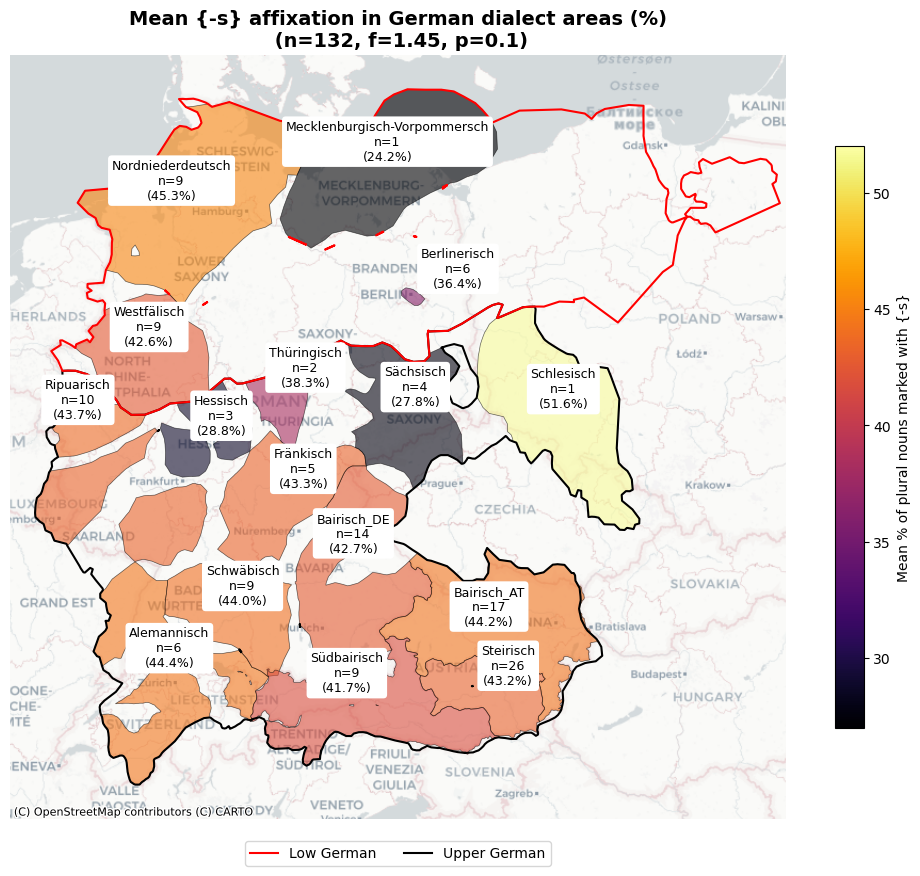

In [73]:
# Load the GeoJSONs
gdf_gjson_mercator = gpd.read_file("./geojson/agg_dialects_gdf_mercator.geojson")
low_gjson_mercator = gpd.read_file("./geojson/low_gdf_mercator.geojson")
notlow_gjson_mercator = gpd.read_file("./geojson/not_low_gdf_mercator.geojson")

# Merge mean values into gdf
gdf_gjson_mercator = gdf_gjson_mercator.merge(results_gdf[["group", "mean_group", "n_group"]], on="group", how="left")

# Plot heatmap choropleth
fig3, ax3 = plt.subplots(figsize=(10, 10))
gdf_gjson_mercator.plot(ax=ax3, column="mean_group",
    cmap="inferno", edgecolor="black", linewidth=0.5,alpha=0.6,
    vmin=27, vmax=52,
    legend=True, legend_kwds={'label': "Mean % of plural nouns marked with {-s}", 'shrink': 0.6},
)

# Add basemap
cx.add_basemap(ax3, source=cx.providers.CartoDB.Positron, crs=gdf_gjson_mercator.crs)

# Title
ax3.set_title("Mean {-s} affixation in German dialect areas (%)\n (n=132, f=1.45, p=0.1)", fontsize=14, fontweight="bold")

# Add region outlines
notlow_gjson_mercator.plot(ax=ax3, edgecolor='black', facecolor='none', linewidth=1.5, zorder=1)
low_gjson_mercator.plot(ax=ax3, edgecolor='red', facecolor='none', linewidth=1.5, zorder=1)

# Add labels with values
texts = []
for idx, row in gdf_gjson_mercator.iterrows():
    if pd.isna(row["mean_group"]):
        continue
    point = row.geometry.representative_point()
    label = row["group"]
    n = row["n_group"]
    value = row["mean_group"]

    if label == "Berlinerisch":
        x, y = point.x + 100000, point.y
    elif label == "Alemannisch":
        x, y = point.x - 60000, point.y
    else:
        x, y = point.x, point.y

    text_str = f"{label}\nn={int(n)}\n({value:.1f}%)"
    txt = ax3.text(x, y, text_str, fontsize=9, ha="center",
                  bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.3"))
    texts.append(txt)

adjust_text(texts, ax=ax3)

# Add custom legend
handles = [
    Line2D([0], [0], color='red', lw=1.5, label='Low German'),
    Line2D([0], [0], color='black', lw=1.5, label='Upper German'),
]
ax3.legend(
    handles=handles,
    loc="lower center",               
    bbox_to_anchor=(0.5, -0.07),      
    ncol=2,                           
)


ax3.set_xlim(570000, 2350000)
ax3.set_axis_off()

plt.tight_layout()
plt.show()

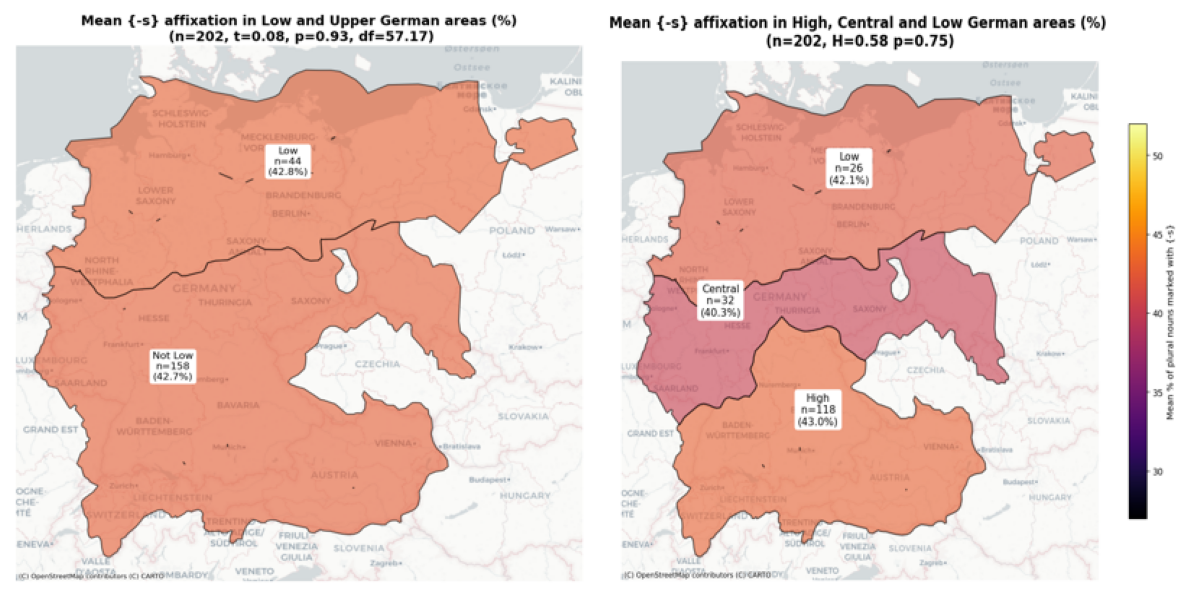

In [74]:
from PIL import Image
target_size = (400,400)
img1 = Image.open("./imgs/final/mean_notlow_heatmap.png").resize(target_size)
img2 = Image.open("./imgs/final/mean_hcl.png").resize(target_size)
#img3 = Image.open("./imgs/final/averages_heatmap.png").resize(target_size)

img1 = np.array(img1)
img2 = np.array(img2)
#img3 = np.array(img3)

fig, axs = plt.subplots(1, 2, figsize=(12, 9))

for ax, img in zip(axs, [img1, img2]):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Moran's I
- Spatial weights: KNN or distance because dialect polygons don't necessarily touch
- KNN isolated and non significant
- distance has significant clustering

In [75]:
gdf = results_gdf.copy()
gdf = gdf[gdf["mean_group"].notna()]
gdf = gdf[gdf["n_group"] > 1]

# gdf= gdf.drop([21,11,14]) #drop any n<5
gdf

group  n_group    variance  median_group  mean_group  \
0         Südbairisch        9  104.340978        42.420   41.664444   
1         Thüringisch        2  207.264800        38.300   38.300000   
2         Bairisch_DE       14   67.078991        42.420   42.712857   
3            Hessisch        3  346.685033        21.210   28.786667   
4          Schwäbisch        9   66.195650        45.450   44.033333   
5           Steirisch       26  105.469098        42.420   43.172308   
6         Westfälisch        9  278.213250        36.360   42.590000   
7           Sächsisch        4  278.381667        21.970   27.770000   
8         Bairisch_AT       17   30.760476        45.450   44.204118   
9         Alemannisch        6  178.838707        43.935   44.443333   
10  Nordniederdeutsch        9  204.711203        45.450   45.264444   
11          Fränkisch        5   72.510470        46.670   43.272000   
12       Berlinerisch        6  117.576137        34.845   36.361667   
13         Ripuarisch       10  158.958600        42.420   43.730000   

    levene_p  levene_stat  kruskal_p  kruskal_stat   anova_p  anova_stat  \
0   0.183275     1.338967   0.316388     18.129166  0.076896    1.601072   
1   0.183275     1.338967   0.316388     18.129166  0.076896    1.601072   
2   0.183275     1.338967   0.316388     18.129166  0.076896    1.601072   
3   0.183275     1.338967   0.316388     18.129166  0.076896    1.601072   
4   0.183275     1.338967   0.316388     18.129166  0.076896    1.601072   
5   0.183275     1.338967   0.316388     18.129166  0.076896    1.601072   
6   0.183275     1.338967   0.316388     18.129166  0.076896    1.601072   
7   0.183275     1.338967   0.316388     18.129166  0.076896    1.601072   
8   0.183275     1.338967   0.316388     18.129166  0.076896    1.601072   
9   0.183275     1.338967   0.316388     18.129166  0.076896    1.601072   
10  0.183275     1.338967   0.316388     18.129166  0.076896    1.601072   
11  0.183275     1.338967   0.316388     18.129166  0.076896    1.601072   
12  0.183275     1.338967   0.316388     18.129166  0.076896    1.601072   
13  0.183275     1.338967   0.316388     18.129166  0.076896    1.601072   

     region                                           geometry  
0      High  POLYGON ((1538323.247 5939859.833, 1534237.603...  
1   Central  POLYGON ((1196719.586 6554925.593, 1192639.839...  
2      High  POLYGON ((1432776.239 6076640.003, 1421004.877...  
3   Central  MULTIPOLYGON (((932266.551 6496317.542, 925769...  
4      High  POLYGON ((1162953.496 6020382.267, 1160994.936...  
5      High  POLYGON ((1636323.140 6068496.980, 1640194.633...  
6       Low  POLYGON ((963710.940 6866817.129, 970819.583 6...  
7   Central  POLYGON ((1408875.389 6701603.485, 1408531.415...  
8      High  POLYGON ((1899912.665 6124663.571, 1901362.317...  
9      High  POLYGON ((994094.605 5914450.123, 973074.476 5...  
10      Low  POLYGON ((789969.521 6952273.816, 799524.176 6...  
11  Central  MULTIPOLYGON (((1015735.786 6381853.061, 10149...  
12      Low  POLYGON ((1505582.528 6870648.630, 1497556.614...  
13  Central  POLYGON ((881715.135 6621089.057, 873830.496 6...

In [76]:
def run_spatial_moran(gdf, values, method="distance"):
    """
    Compute and plot Moran's I across a range of spatial lags.

    Parameters:
    - gdf: GeoDataFrame with a 'mean_group' column and geometry
    - method: "distance" or "knn"
    - param: distance in meters (if method="distance") or k-neighbors (if method="knn")
    """
    gdf_centroids = gdf.copy()
    gdf_centroids["geometry"] = gdf.geometry.centroid

    # Choose thresholds to loop over
    if method == "distance":
        thresholds = list(range(200_000, 650_000, 50_000))  # meters
        label_suffix = "km"
        params = values
        x_vals = [d // 1000 for d in params]  # km
    elif method == "knn":
        k_vals = values
        label_suffix = "neighbors"
        params = k_vals
        x_vals = k_vals
    else:
        raise ValueError("Method must be 'distance' or 'knn'")

    moran_stats = []
    p_vals = []

    for p in params:
        if method == "distance":
            w = DistanceBand.from_dataframe(gdf_centroids, threshold=p, binary=True)
        elif method == "knn":
            w = KNN.from_dataframe(gdf_centroids, k=p)

        w.transform = "r"

        # skip if all are islands
        if len(w.islands) == len(gdf):
            moran_stats.append(float("nan"))
            p_vals.append(1.0)
            continue

        y = gdf["mean_group"].values
        moran = Moran(y, w)
        moran_stats.append(moran.I)
        p_vals.append(moran.p_sim)

        print(f"{method.title()} param = {p}{label_suffix}")
        print("  Islands:", w.islands)
        print(f"  Moran's I: {moran.I:.3f}, p-value: {moran.p_sim:.4f}")

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, moran_stats, marker="o")
    plt.xlabel(f"{method.title()} Threshold ({label_suffix})", fontsize=12)
    plt.ylabel("Moran's I", fontsize=12)
    plt.title(f"Spatial Autocorrelation vs. {method.title()} Threshold")
    plt.grid(True)
    plt.show()

    return x_vals, moran_stats, p_vals

def run_lisa(gdf, values, method="knn", value_col="mean_group"):
    """
    Generate Local Moran (LISA) cluster maps for multiple spatial weights.

    Parameters:
    - gdf: GeoDataFrame with geometry and value column
    - values: list of k values (if method='knn') or distance thresholds in meters (if method='distance')
    - method: 'knn' or 'distance'
    - value_col: column in gdf to compute LISA on
    """
    n = len(values)
    ncols = 4
    nrows = (n + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 15))
    axes = axes.flatten()

    for idx, val in enumerate(values):
        gdf_copy = gdf.copy()
        gdf_copy["geometry"] = gdf.geometry.centroid

        if method == "knn":
            w = KNN.from_dataframe(gdf_copy, k=val)
            title_val = f"k={val}"
        elif method == "distance":
            w = DistanceBand.from_dataframe(gdf_copy, threshold=val, binary=True)
            title_val = f"{val // 1000} km"
        else:
            raise ValueError("Method must be 'knn' or 'distance'")

        w.transform = "r"
        y = gdf_copy[value_col].values
        moran = Moran(y, w)
        lisa = Moran_Local(y, w)

        gdf_copy["Is"] = lisa.Is
        gdf_copy["q"] = lisa.q
        gdf_copy["p_sim"] = lisa.p_sim

        significant = gdf_copy[gdf_copy["p_sim"] < 0.05].copy()
        significant["cluster"] = significant["q"]


        print(f"\n--- {title_val} ---")
        print(significant[["group", "Is", "p_sim", "cluster"]])

        ax = axes[idx]
        lisa_cluster(lisa, gdf, p=0.05, ax=ax)
        ax.set_title(f"{title_val}\nI={moran.I:.2f}, p={moran.p_sim:.3f}", fontsize=14)
        for _, row in significant.iterrows():
            if row["geometry"].geom_type == "Polygon":
                centroid = row["geometry"].centroid
            else:
                centroid = row["geometry"].representative_point()
            
            ax.annotate(f"I={row['Is']:.2f} (p={row['p_sim']:.2f})", 
                        xy=(centroid.x, centroid.y), 
                        ha='center', fontsize=14, color="black",
                        bbox=dict(facecolor="white", edgecolor="none", boxstyle="round,pad=0.3"))
        cx.add_basemap(ax, source=cx.providers.CartoDB.Positron, crs=gdf.crs)

    # Remove unused subplots
    for j in range(len(values), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## Distance Moran

/opt/anaconda3/envs/gds/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 14 disconnected components.
 There are 14 islands with ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13.
  w = W(neighbors, weights, ids, **kwargs)
/opt/anaconda3/envs/gds/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 14 disconnected components.
 There are 14 islands with ids: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13.
  W.__init__(


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 10, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 12, ' is an island (no neighbors)')
('WARNING: ', 13, ' is an island (no neighbors)')
('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 5, ' is an island (no neighbors)')
('WARNING: ', 6,

/opt/anaconda3/envs/gds/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
 There are 10 islands with ids: 0, 1, 2, 4, 6, 7, 9, 10, 12, 13.
  w = W(neighbors, weights, ids, **kwargs)
/opt/anaconda3/envs/gds/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
 There are 10 islands with ids: 0, 1, 2, 4, 6, 7, 9, 10, 12, 13.
  W.__init__(
/opt/anaconda3/envs/gds/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 0, 2, 7, 10, 12.
  w = W(neighbors, weights, ids, **kwargs)
/opt/anaconda3/envs/gds/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.


Distance param = 250000km
  Islands: [0, 2, 7, 10, 12]
  Moran's I: 0.105, p-value: 0.2470
('WARNING: ', 10, ' is an island (no neighbors)')


/opt/anaconda3/envs/gds/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 10.
  w = W(neighbors, weights, ids, **kwargs)
/opt/anaconda3/envs/gds/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 10.
  W.__init__(


Distance param = 300000km
  Islands: [10]
  Moran's I: 0.300, p-value: 0.0860
('WARNING: ', 10, ' is an island (no neighbors)')
Distance param = 350000km
  Islands: [10]
  Moran's I: 0.294, p-value: 0.0710


/opt/anaconda3/envs/gds/lib/python3.12/site-packages/libpysal/weights/util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 10.
  w = W(neighbors, weights, ids, **kwargs)
/opt/anaconda3/envs/gds/lib/python3.12/site-packages/libpysal/weights/distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 10.
  W.__init__(


Distance param = 400000km
  Islands: []
  Moran's I: 0.193, p-value: 0.0850
Distance param = 450000km
  Islands: []
  Moran's I: 0.147, p-value: 0.0900
Distance param = 500000km
  Islands: []
  Moran's I: 0.241, p-value: 0.0190
Distance param = 550000km
  Islands: []
  Moran's I: 0.032, p-value: 0.1740
Distance param = 600000km
  Islands: []
  Moran's I: 0.063, p-value: 0.0900


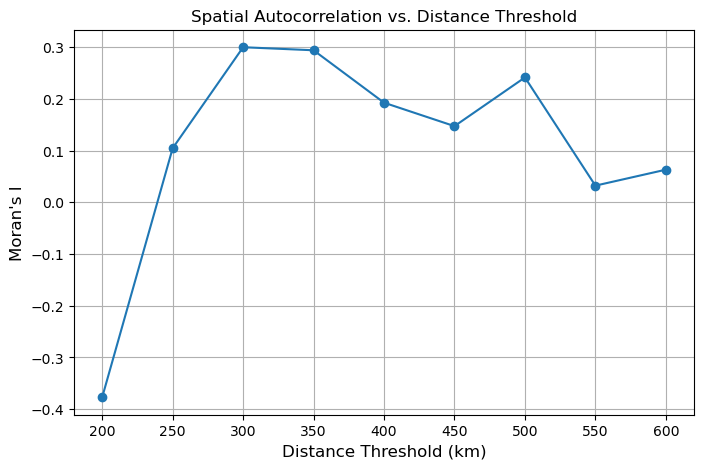

([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600],
 [nan,
  nan,
  nan,
  -0.37685595042610726,
  0.10457768405887363,
  0.29985737712557126,
  0.2939561651176045,
  0.19260263063904773,
  0.14726145881369196,
  0.24142938138739475,
  0.03223204388858881,
  0.06308728030891116],
 [1.0, 1.0, 1.0, 0.287, 0.247, 0.086, 0.071, 0.085, 0.09, 0.019, 0.174, 0.09])

In [77]:
distance_thresholds = list(range(50000, 650000, 50000))  
run_spatial_moran(gdf,distance_thresholds, method="distance")

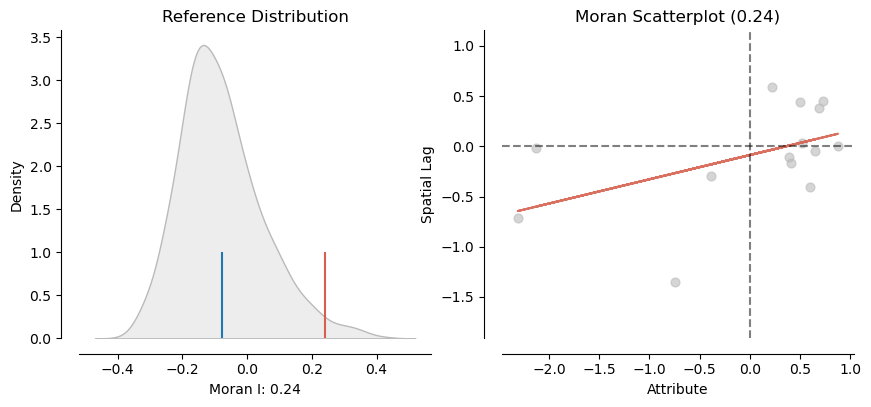

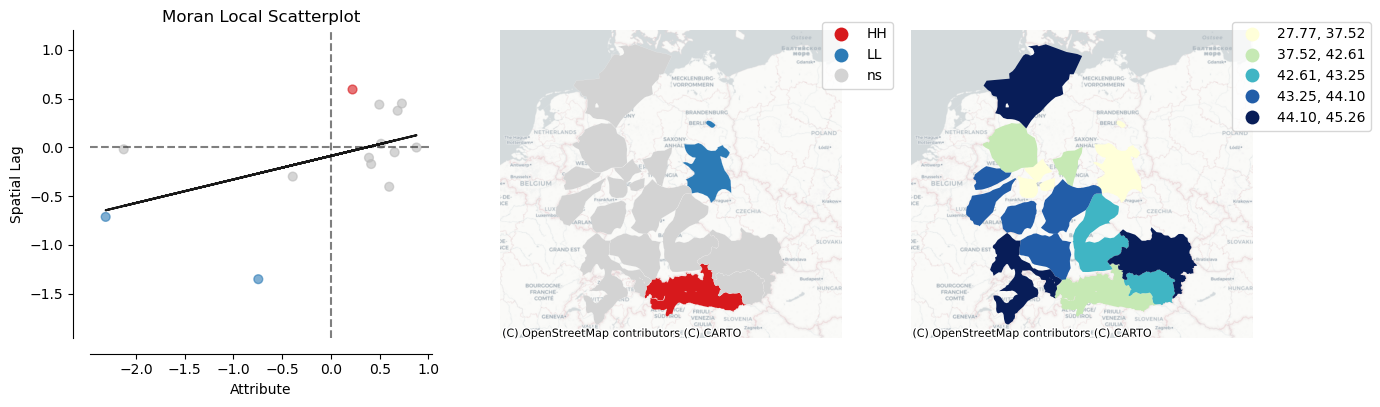

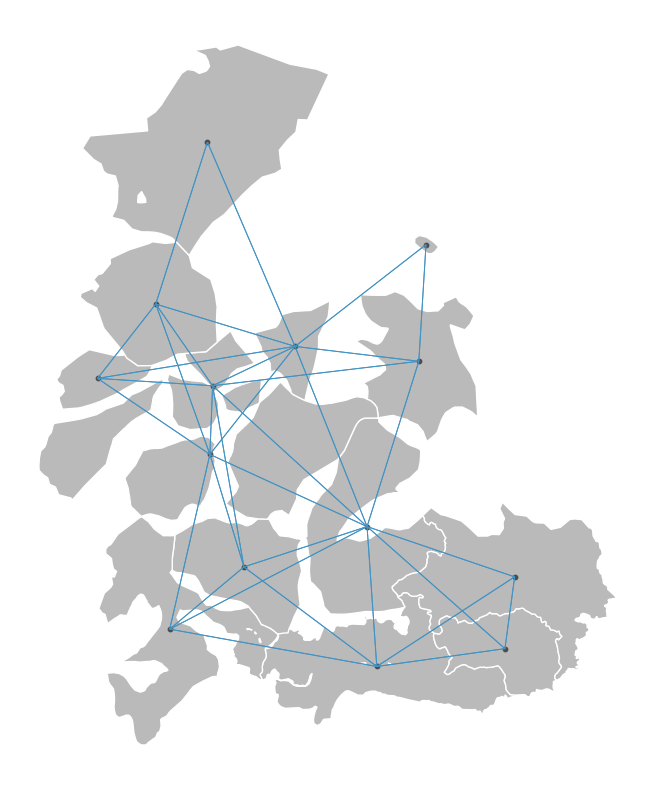

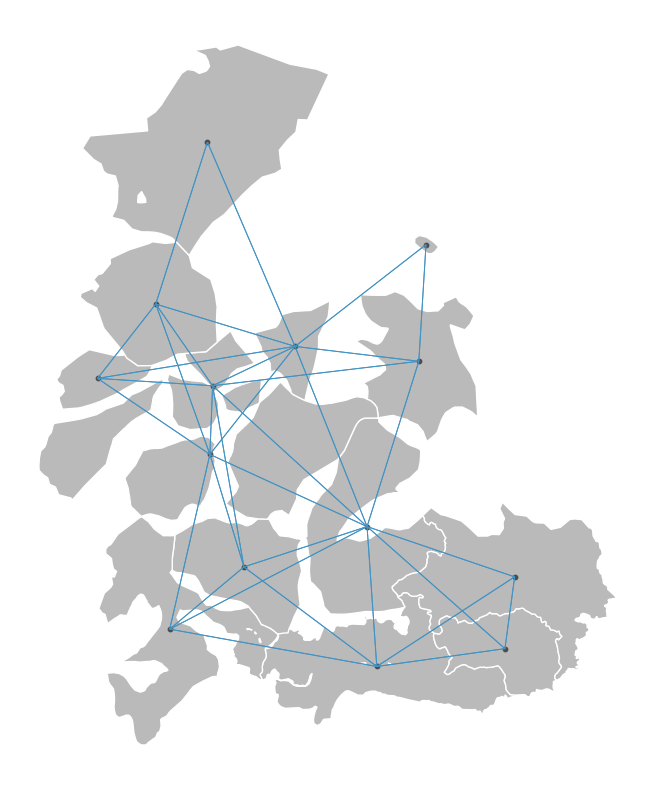

In [78]:
#at 500,000
gdf = gdf.to_crs(epsg=3857)

#create spatial weights
w = DistanceBand.from_dataframe(gdf,500000)
w.transform = "r"

#variable for spatial autocorrelation
y = gdf["mean_group"].values

moran = Moran(y, w)
lisa = Moran_Local(y, w)

plot_moran(moran)
plt.show()

fig, axarr = plot_local_autocorrelation(
    lisa,
    gdf,
    attribute="mean_group",
    p=0.05,
)

cx.add_basemap(axarr[1], source=cx.providers.CartoDB.Positron, crs=gdf.crs)
cx.add_basemap(axarr[2], source=cx.providers.CartoDB.Positron, crs=gdf.crs)
plt.show()

weights = DistanceBand.from_dataframe(gdf,500_000)
plot_spatial_weights(weights, gdf)
plt.show()

wnp = nonplanar_neighbors(weights, gdf)
plot_spatial_weights(wnp, gdf)
plt.show()


--- 400 km ---
           group        Is  p_sim  cluster
1    Thüringisch  0.311322  0.008        3
12  Berlinerisch  0.935069  0.025        3

--- 450 km ---
           group        Is  p_sim  cluster
1    Thüringisch  0.169866  0.016        3
12  Berlinerisch  0.935069  0.024        3

--- 500 km ---
           group        Is  p_sim  cluster
7      Sächsisch  1.529121  0.004        3
12  Berlinerisch  0.935069  0.029        3

--- 550 km ---
         group        Is  p_sim  cluster
0  Südbairisch  0.122170  0.049        1
7    Sächsisch  0.590839  0.022        3


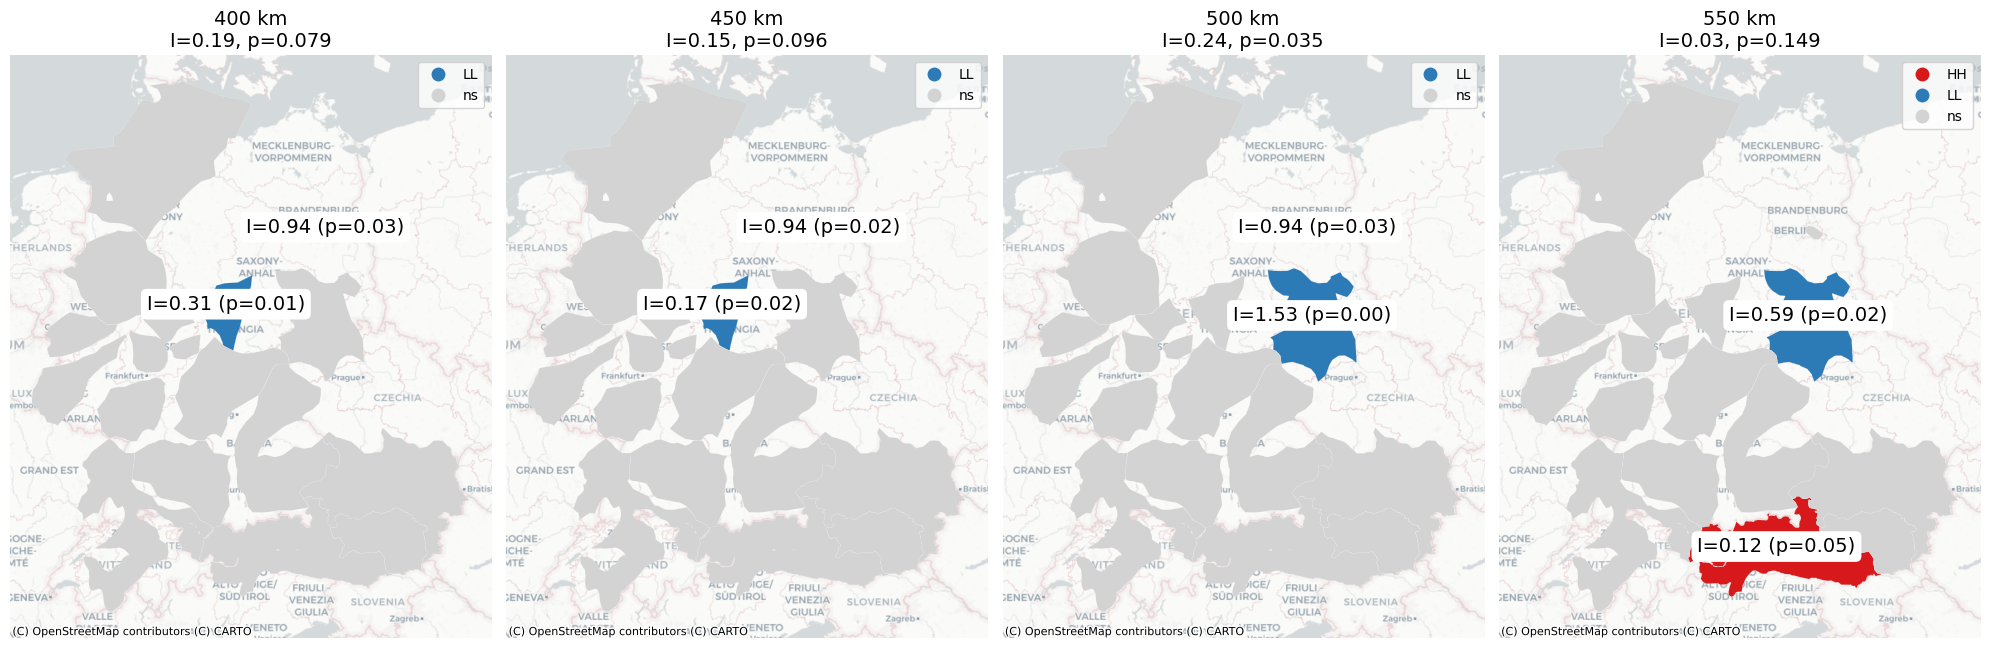

In [79]:
run_lisa(gdf, [400000,450000,500000,550000], method="distance", value_col="mean_group")

## KNN Moran

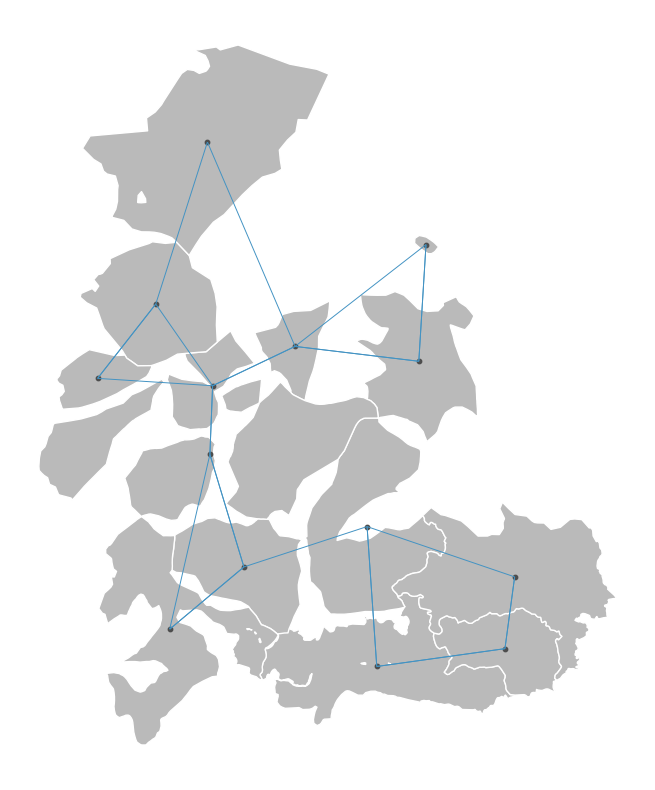

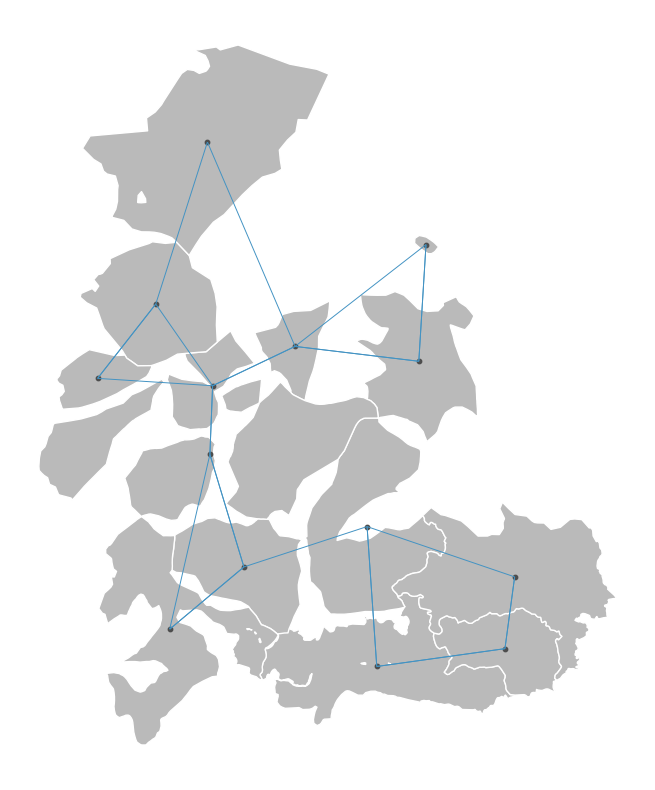

In [81]:
weights = KNN.from_dataframe(gdf)
plot_spatial_weights(weights, gdf)
plt.show()

wnp = nonplanar_neighbors(weights, gdf)
plot_spatial_weights(wnp, gdf)
plt.show()

/opt/anaconda3/envs/gds/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


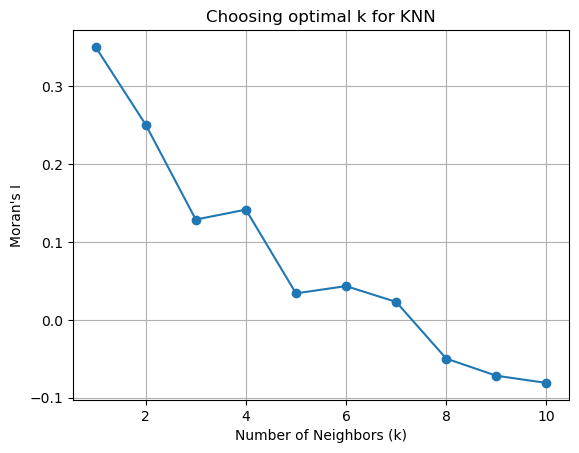

In [82]:
moran_stats = []
k_range = range(1, 11)

for k in k_range:
    w = KNN.from_dataframe(gdf, k=k)
    w.transform = "r"
    moran = Moran(gdf["mean_group"], w)
    moran_stats.append(moran.I)

plt.plot(k_range, moran_stats, marker="o")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Moran's I")
plt.title("Choosing optimal k for KNN")
plt.grid(True)
plt.show()

/opt/anaconda3/envs/gds/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 5 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)



--- k=1 ---
Empty DataFrame
Columns: [group, Is, p_sim, cluster]
Index: []

--- k=2 ---
           group        Is  p_sim  cluster
1    Thüringisch  0.807238  0.009        3
12  Berlinerisch  0.935069  0.023        3

--- k=3 ---
         group        Is  p_sim  cluster
1  Thüringisch  0.475783  0.019        3

--- k=4 ---
           group        Is  p_sim  cluster
1    Thüringisch  0.321362  0.026        3
7      Sächsisch  1.529121  0.009        3
12  Berlinerisch  0.683467  0.007        3

--- k=5 ---
           group        Is  p_sim  cluster
1    Thüringisch  0.311322  0.007        3
7      Sächsisch  1.002604  0.009        3
12  Berlinerisch  0.492812  0.021        3

--- k=6 ---
                group        Is  p_sim  cluster
0         Südbairisch  0.119417  0.039        1
1         Thüringisch  0.234427  0.010        3
7           Sächsisch  0.590839  0.039        3
10  Nordniederdeutsch -0.622679  0.010        4
12       Berlinerisch  0.363127  0.039        3

--- k=7 ---
   

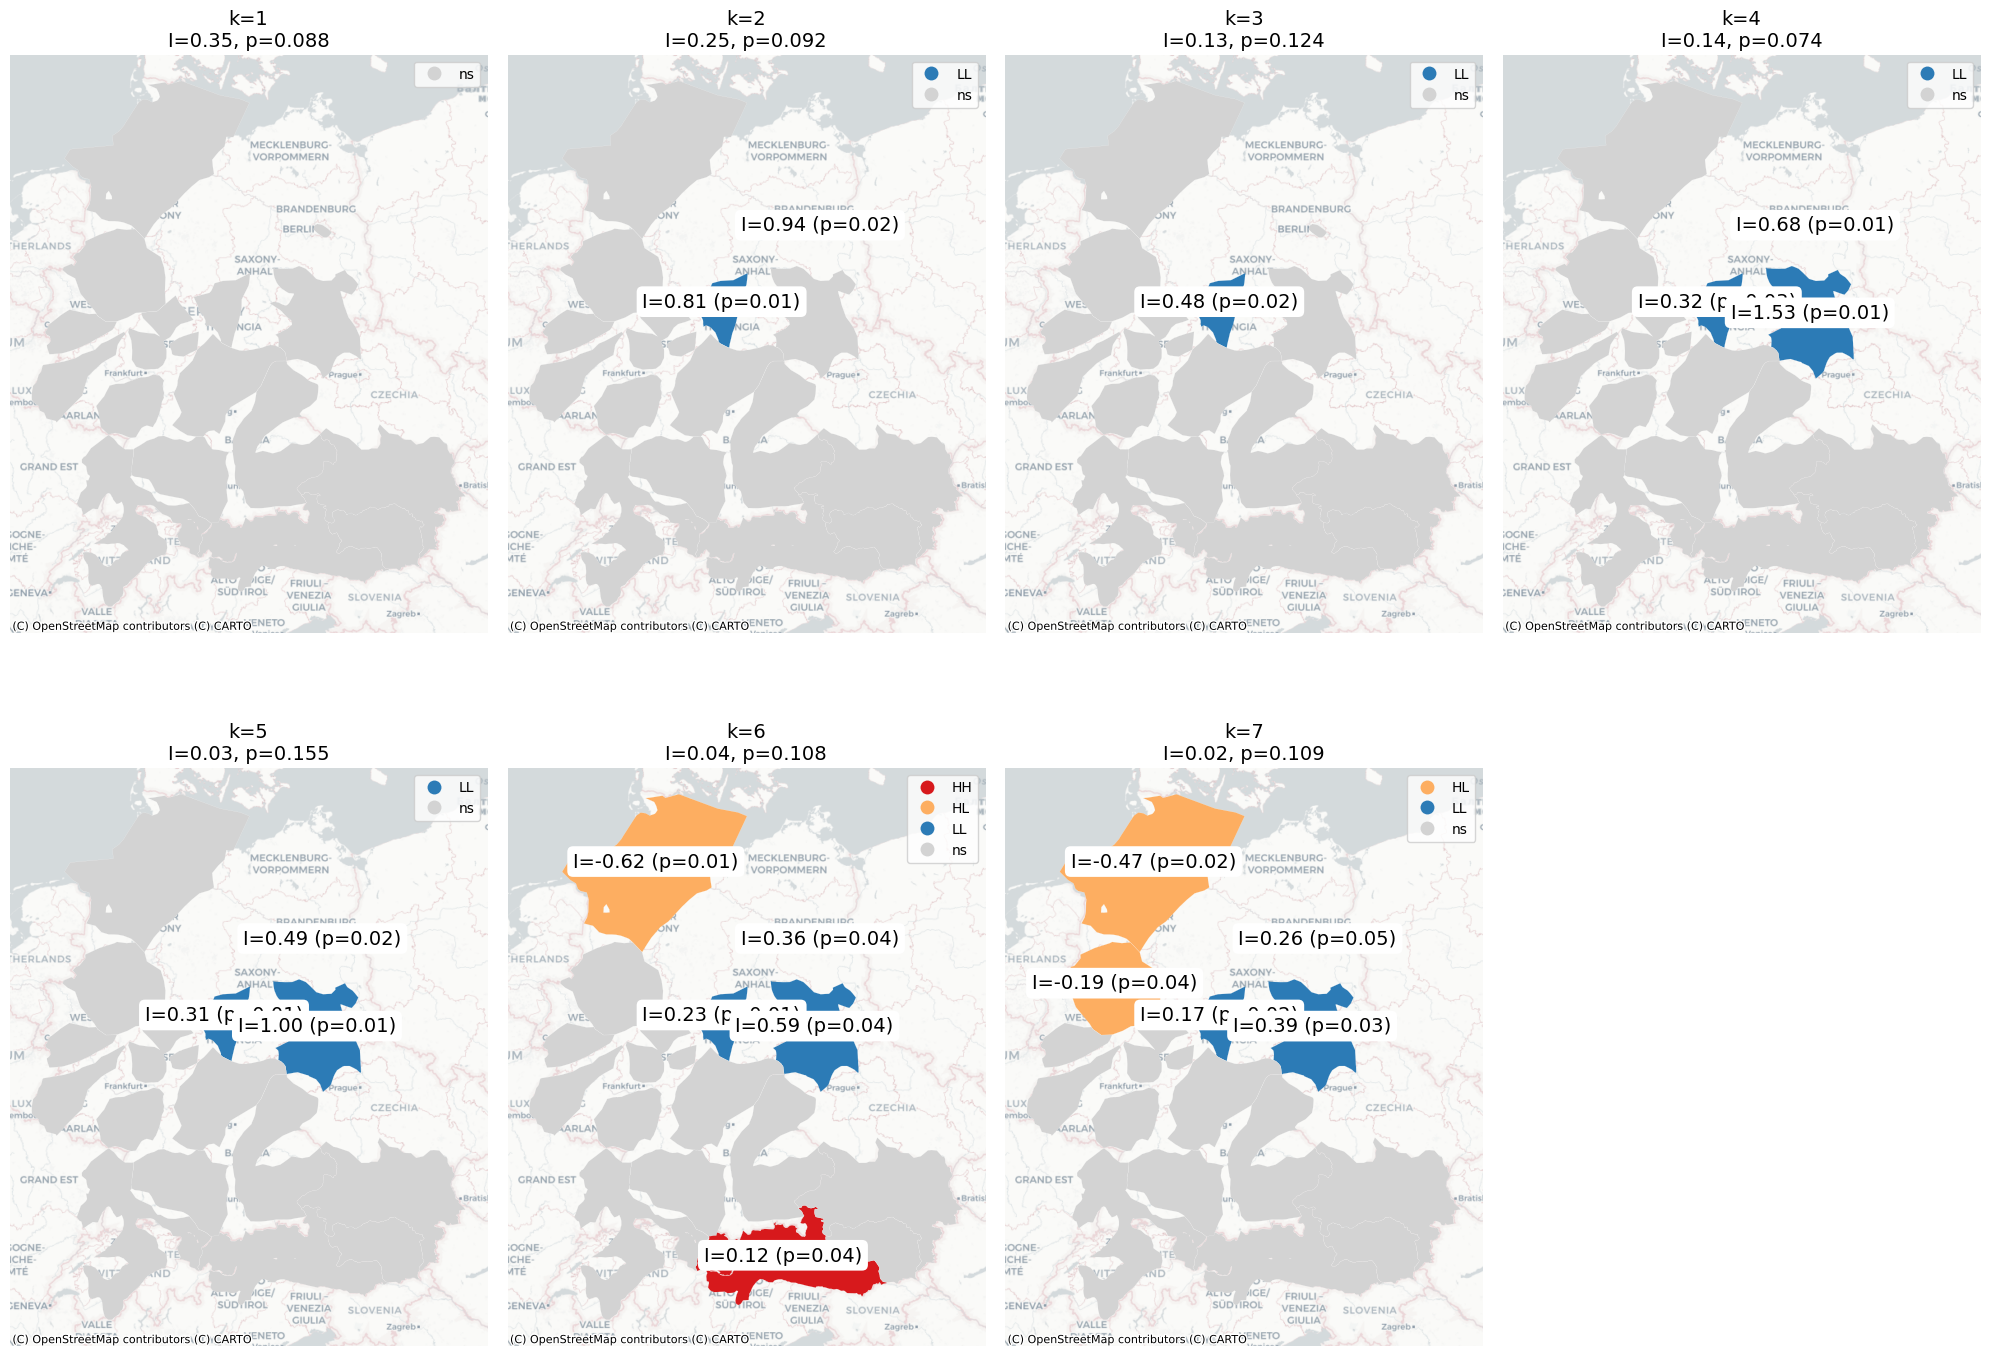

In [83]:
k = [1,2,3,4,5,6,7]
run_lisa(gdf, method="knn",values=k)

#: Specific dialects cluster in terms of {-s} use: low in central east, high in south west
#higher k shows austro-bavarian block that is consistent

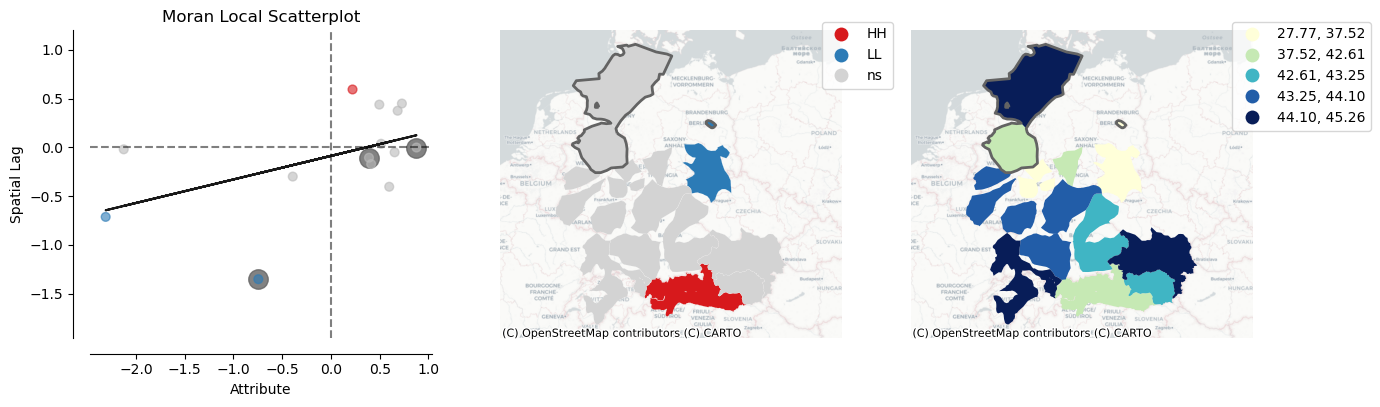

In [84]:
fig, axarr = plot_local_autocorrelation(
    lisa,
    gdf,
    attribute="mean_group",
    p=0.05,
    region_column="region",     # name of the column with groupings
    mask=["Low"],   # values to keep highlighted
)

cx.add_basemap(axarr[1], source=cx.providers.CartoDB.Positron, crs=gdf.crs)
cx.add_basemap(axarr[2], source=cx.providers.CartoDB.Positron, crs=gdf.crs)

plt.show()